# Introduction to Portfolio Theory – Python Lab

**Winter School: AI and Finance**

We’ll cover:

1. Risk & return as random variables  
2. Two-asset portfolios and diversification  
3. Multi-asset portfolios and the Markowitz bullet  
4. Minimum-variance portfolios and efficient frontier  
5. CAPM-style regression and beta estimation  

You’re encouraged to **tweak parameters, rerun cells, and create your own portfolios**.


In [ ]:
# %% Imports and global setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for optimization (Markowitz)
from scipy.optimize import minimize

# nice plotting defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

np.random.seed(42)  # reproducibility


## 1. Simulating Asset Returns

We start by **simulating monthly returns** for a few synthetic assets:

- A "defensive" stock  
- A "growth" stock  
- A "cyclical" stock  
- A **market index** (for CAPM-style analysis later)

We'll assume multivariate normal returns with a specified **mean vector** and **covariance matrix**.


In [ ]:
# %% Simulate monthly returns for 4 assets over 5 years (60 months)

n_months = 60

# Annualized expected returns and volatilities (rough toy numbers)
mu_annual = np.array([0.08, 0.12, 0.16, 0.10])   # [defensive, growth, cyclical, market]
sigma_annual = np.array([0.12, 0.20, 0.30, 0.15])

# Convert to monthly
mu_monthly = mu_annual / 12
sigma_monthly = sigma_annual / np.sqrt(12)

# Correlation matrix
corr = np.array([
    [1.0, 0.6, 0.3, 0.7],   # defensive
    [0.6, 1.0, 0.5, 0.8],   # growth
    [0.3, 0.5, 1.0, 0.6],   # cyclical
    [0.7, 0.8, 0.6, 1.0],   # market
])

# Build covariance matrix: Sigma = D * Corr * D
D = np.diag(sigma_monthly)
cov_monthly = D @ corr @ D

# Draw samples from multivariate normal
returns = np.random.multivariate_normal(mu_monthly, cov_monthly, size=n_months)

asset_names = ["Defensive", "Growth", "Cyclical", "Market"]
returns_df = pd.DataFrame(returns, columns=asset_names)
print(returns_df.shape)
returns_df.head()


(60, 4)


,Defensive,Growth,Cyclical,Market
0,-0.032044,-0.012819,-0.025575,0.004573
1,-0.031952,0.033843,0.037446,0.010214
2,0.039417,0.043670,0.035472,0.032306
3,0.003943,-0.089902,0.054986,-0.030149
4,0.062445,0.056878,0.088397,0.037366


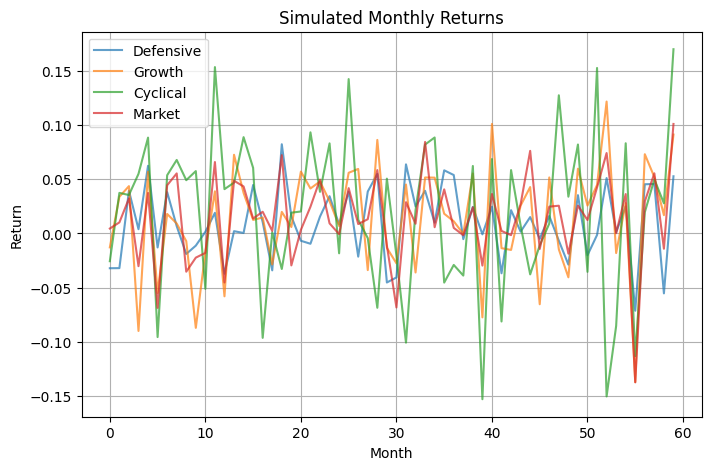

In [ ]:
# %% Plot asset monthly returns

fig, ax = plt.subplots()
for col in asset_names:
    ax.plot(returns_df.index, returns_df[col], label=col, alpha=0.7)

ax.set_title("Simulated Monthly Returns")
ax.set_xlabel("Month")
ax.set_ylabel("Return")
ax.legend()
plt.show()


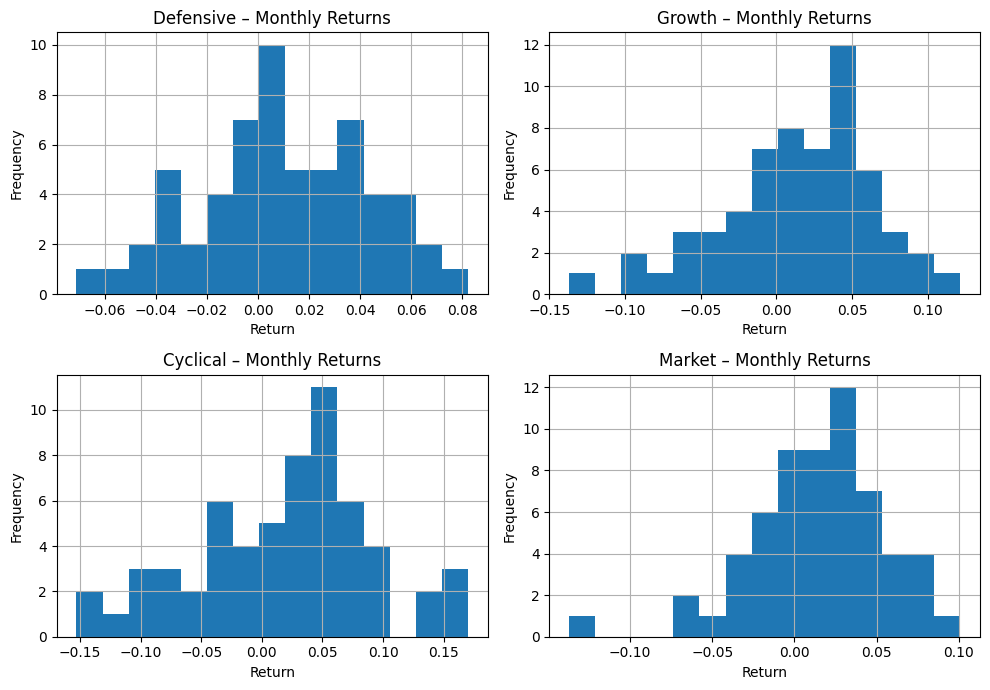

In [ ]:
# %% Histograms of returns

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.ravel()

for i, col in enumerate(asset_names):
    axes[i].hist(returns_df[col], bins=15)
    axes[i].set_title(f"{col} – Monthly Returns")
    axes[i].set_xlabel("Return")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# %% Empirical means and standard deviations (annualized back)

mean_monthly = returns_df.mean()
std_monthly = returns_df.std()

mean_annual_est = mean_monthly * 12
std_annual_est = std_monthly * np.sqrt(12)

summary = pd.DataFrame({
    "mu_annual_est": mean_annual_est,
    "sigma_annual_est": std_annual_est
})
summary


,mu_annual_est,sigma_annual_est
Defensive,0.119182,0.114609
Growth,0.173658,0.173817
Cyclical,0.229473,0.253827
Market,0.176422,0.140141


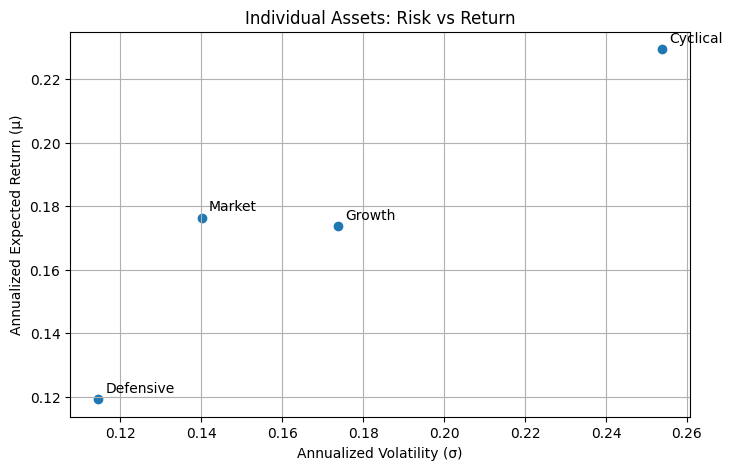

In [ ]:
# %% Risk-return scatter (annualized)

fig, ax = plt.subplots()
ax.scatter(summary["sigma_annual_est"], summary["mu_annual_est"])

for name in asset_names:
    ax.annotate(name,
                (summary.loc[name, "sigma_annual_est"],
                 summary.loc[name, "mu_annual_est"]),
                xytext=(5, 5), textcoords="offset points")

ax.set_xlabel("Annualized Volatility (σ)")
ax.set_ylabel("Annualized Expected Return (μ)")
ax.set_title("Individual Assets: Risk vs Return")
plt.show()


### Link to Theory

- We have treated returns as **random variables** with means and variances
- The plot above is analogous to plotting points in the **σ–μ plane** as in your slides (Risk & Return, Two Securities, etc.).

Next we build **two-asset portfolios** and see how **correlation and diversification** affect risk.


## 2. Two-Asset Portfolios and Diversification

We now pick **two assets** and build portfolios with different weights.

From theory:

- Portfolio return:  
  $\mu_V = w \mu_1 + (1-w)\mu_2$
- Portfolio variance:  
  $\sigma_V^2 = w^2 \sigma_1^2 + (1-w)^2 \sigma_2^2 + 2w(1-w)\rho_{12}\sigma_1\sigma_2$

We'll estimate $ \mu $, $ \sigma $, and $ \rho $ empirically from our simulated data, and then:

- Compute portfolio μ, σ for **w from 0 to 1**  
- Plot the **portfolio line** in the σ–μ plane  
- Visualize the **diversification effect**


In [ ]:
# %% Two-asset portfolio: Defensive & Growth

asset1 = "Defensive"
asset2 = "Growth"

mu1 = mean_annual_est[asset1]
mu2 = mean_annual_est[asset2]
sigma1 = std_annual_est[asset1]
sigma2 = std_annual_est[asset2]
rho12 = returns_df[[asset1, asset2]].corr().iloc[0, 1]

mu1, mu2, sigma1, sigma2, rho12


(np.float64(0.11918190668313092),
 np.float64(0.17365788347539293),
 np.float64(0.11460893463948704),
 np.float64(0.17381694699893432),
 np.float64(0.540173296308609))

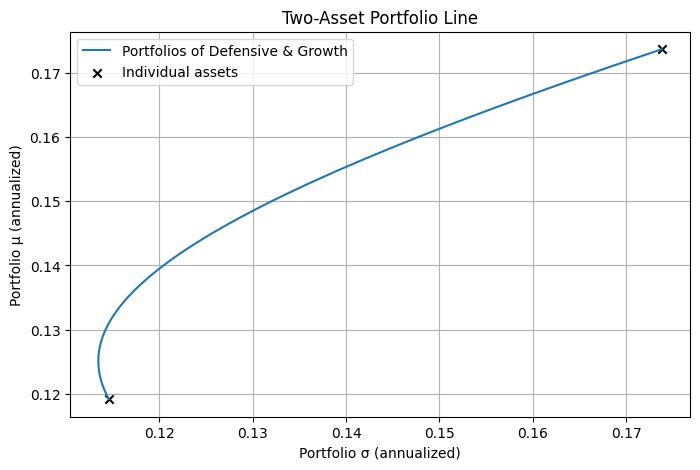

In [ ]:
# %% Compute portfolio μ and σ for w in [0, 1]

weights = np.linspace(0, 1, 101)
mu_port = weights * mu1 + (1 - weights) * mu2
sigma_port = np.sqrt(
    (weights**2) * sigma1**2 +
    ((1 - weights)**2) * sigma2**2 +
    2 * weights * (1 - weights) * rho12 * sigma1 * sigma2
)

fig, ax = plt.subplots()
ax.plot(sigma_port, mu_port, label="Portfolios of Defensive & Growth")
ax.scatter([sigma1, sigma2], [mu1, mu2], color="black", marker="x", label="Individual assets")
ax.set_xlabel("Portfolio σ (annualized)")
ax.set_ylabel("Portfolio μ (annualized)")
ax.set_title("Two-Asset Portfolio Line")
ax.legend()
plt.show()


Minimum-variance weight on Defensive: 0.891
Portfolio μ_min = 12.511%, σ_min = 11.348%


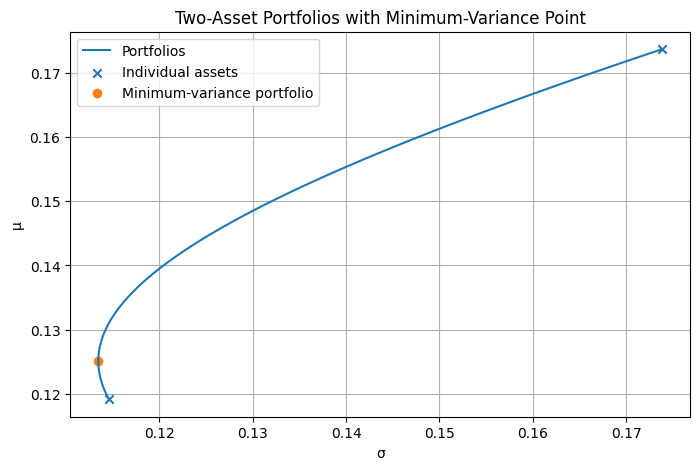

In [ ]:
# %% Find minimum-variance weight analytically and mark it

# according to theory:
w_min = (sigma2**2 - rho12 * sigma1 * sigma2) / (sigma1**2 + sigma2**2 - 2 * rho12 * sigma1 * sigma2)

mu_min = w_min * mu1 + (1 - w_min) * mu2
sigma_min = np.sqrt(
    (w_min**2) * sigma1**2 +
    ((1 - w_min)**2) * sigma2**2 +
    2 * w_min * (1 - w_min) * rho12 * sigma1 * sigma2
)

print(f"Minimum-variance weight on {asset1}: {w_min:.3f}")
print(f"Portfolio μ_min = {mu_min:.3%}, σ_min = {sigma_min:.3%}")

fig, ax = plt.subplots()
ax.plot(sigma_port, mu_port, label="Portfolios")
ax.scatter([sigma1, sigma2], [mu1, mu2], marker="x", label="Individual assets")
ax.scatter([sigma_min], [mu_min], marker="o", label="Minimum-variance portfolio")
ax.set_xlabel("σ")
ax.set_ylabel("μ")
ax.set_title("Two-Asset Portfolios with Minimum-Variance Point")
ax.legend()
plt.show()


### 🧪 Try This

- Change `asset1` and `asset2` to other combinations, e.g.:
  - Defensive & Cyclical
  - Growth & Cyclical  
- Observe how the **shape of the curve** and **location of minimum variance** changes with correlation $ \rho_{12} $.  


## 3. Multi-Asset Portfolios and the Markowitz Bullet

Now consider **three risky assets**:

- Defensive  
- Growth  
- Cyclical  

We’ll:

1. Generate many **random portfolios**  
2. Plot them in the **$\sigma$-$\mu$ plane**  
3. Visualize the **Markowitz bullet**  
4. Approximate the **efficient frontier** by taking the best portfolios for each risk level


In [ ]:
# %% Helper functions for portfolios

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)


def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights @ cov_matrix @ weights.T)


In [ ]:
# %% Random portfolios for 3 risky assets

risky_assets = ["Defensive", "Growth", "Cyclical"]
mean_risky = mean_annual_est[risky_assets].values
cov_risky = (returns_df[risky_assets].cov() * 12).values  # annualized covariance

n_portfolios = 100000
all_weights = []
all_returns = []
all_vols = []

for _ in range(n_portfolios):
    # random weights that sum to 1
    w = np.random.rand(len(risky_assets))
    w /= w.sum()
    all_weights.append(w)
    all_returns.append(portfolio_return(w, mean_risky))
    all_vols.append(portfolio_volatility(w, cov_risky))

portfolios_df = pd.DataFrame({
    "vol": all_vols,
    "ret": all_returns
})
portfolios_df.head()


,vol,ret
0,0.110925,0.132207
1,0.127564,0.168208
2,0.115905,0.155319
3,0.157820,0.190997
4,0.151016,0.182803


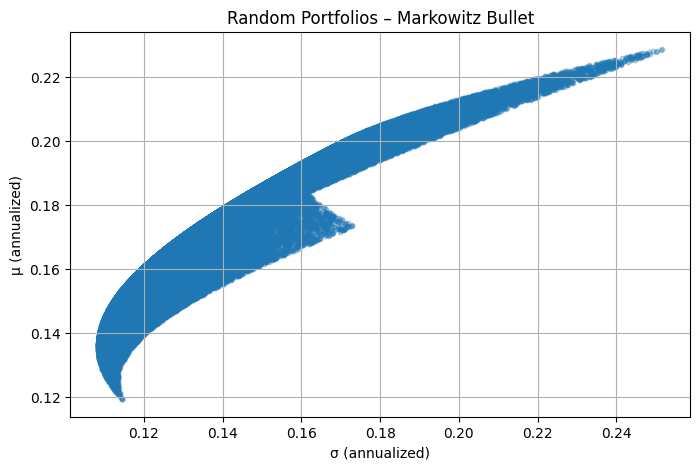

In [ ]:
# %% Plot the Markowitz bullet

fig, ax = plt.subplots()
ax.scatter(portfolios_df["vol"], portfolios_df["ret"], alpha=0.3, s=10)
ax.set_xlabel("σ (annualized)")
ax.set_ylabel("μ (annualized)")
ax.set_title("Random Portfolios – Markowitz Bullet")
plt.show()


/tmp/ipython-input-2016835816.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = portfolios_df.groupby(pd.cut(portfolios_df["vol"], bins))


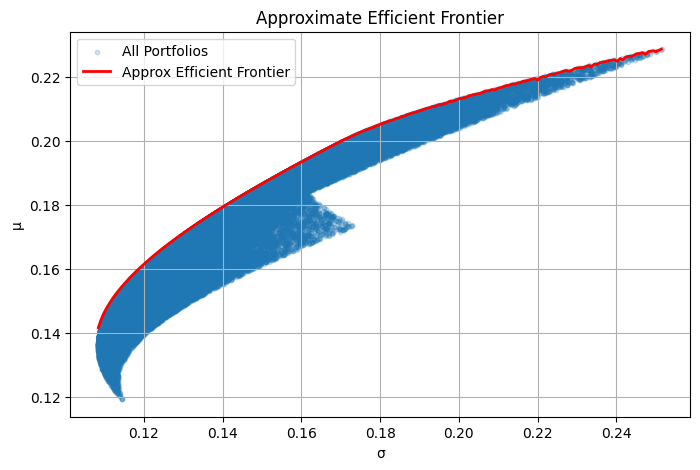

In [ ]:
# %% Approximate efficient frontier: take best return for each vol bucket

bins = np.linspace(portfolios_df["vol"].min(), portfolios_df["vol"].max(), 200)
groups = portfolios_df.groupby(pd.cut(portfolios_df["vol"], bins))

frontier_vol = []
frontier_ret = []
for _, group in groups:
    if len(group) == 0:
        continue
    frontier_vol.append(group["vol"].min())
    frontier_ret.append(group["ret"].max())

fig, ax = plt.subplots()
ax.scatter(portfolios_df["vol"], portfolios_df["ret"], alpha=0.2, s=10, label="All Portfolios")
ax.plot(frontier_vol, frontier_ret, color='red', linewidth=2, label="Approx Efficient Frontier")
ax.set_xlabel("σ")
ax.set_ylabel("μ")
ax.set_title("Approximate Efficient Frontier")
ax.legend()
plt.show()


We’ve just numerically reproduced:

- The **attainable set** of portfolios (shaded area)  
- The **minimum variance line / efficient frontier** (upper boundary)


## 4. Markowitz Optimization via `scipy.optimize`

We now solve the **continuous optimization problems**:

1. **Minimum-variance portfolio** (MVP):  
   Minimize $\sigma^2$ subject to weights summing to 1.

2. **Minimum variance for a target return** $\mu_{target}$:  
   Minimize $\sigma^2$ subject to weights summing to 1 and $\mu=\mu_{target}$.


In [ ]:
# %% Optimization helpers

n_assets = len(risky_assets)

def portfolio_stats(weights, mean_returns, cov_matrix):
    mu = portfolio_return(weights, mean_returns)
    sigma = portfolio_volatility(weights, cov_matrix)
    return mu, sigma

def min_variance(mean_returns, cov_matrix):
    # minimize variance
    def objective(weights):
        return portfolio_volatility(weights, cov_matrix) ** 2

    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
    )
    bounds = tuple((0, 1) for _ in range(n_assets))
    w0 = np.ones(n_assets) / n_assets

    result = minimize(objective, w0, method="SLSQP", bounds=bounds, constraints=constraints)
    return result.x

def min_var_given_return(mean_returns, cov_matrix, target_return):
    def objective(weights):
        return portfolio_volatility(weights, cov_matrix) ** 2

    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w: portfolio_return(w, mean_returns) - target_return},
    )
    bounds = tuple((0, 1) for _ in range(n_assets))
    w0 = np.ones(n_assets) / n_assets

    result = minimize(objective, w0, method="SLSQP", bounds=bounds, constraints=constraints)
    return result.x


In [ ]:
# %% Global minimum-variance portfolio

w_mvp = min_variance(mean_risky, cov_risky)
mu_mvp, sigma_mvp = portfolio_stats(w_mvp, mean_risky, cov_risky)

print("MVP Weights (Defensive, Growth, Cyclical):")
for asset, w in zip(risky_assets, w_mvp):
    print(f"  {asset}: {w:.3f}")
print(f"\nMVP Expected Return: {mu_mvp:.3%}")
print(f"MVP Volatility:      {sigma_mvp:.3%}")

MVP Weights (Defensive, Growth, Cyclical):
  Defensive: 0.831
  Growth: 0.037
  Cyclical: 0.132

MVP Expected Return: 13.574%
MVP Volatility:      10.841%


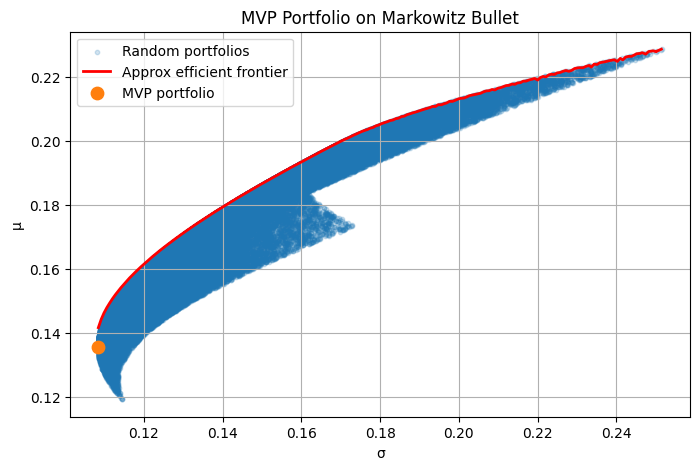

In [ ]:
# %% Plot MVP portfolio on Markowitz bullet

fig, ax = plt.subplots()
ax.scatter(portfolios_df["vol"], portfolios_df["ret"], alpha=0.2, s=10, label="Random portfolios")
ax.plot(frontier_vol, frontier_ret, color='red', linewidth=2, label="Approx efficient frontier")
ax.scatter([sigma_mvp], [mu_mvp], marker="o", s=80, label="MVP portfolio")
ax.set_xlabel("σ")
ax.set_ylabel("μ")
ax.set_title("MVP Portfolio on Markowitz Bullet")
ax.legend()
plt.show()


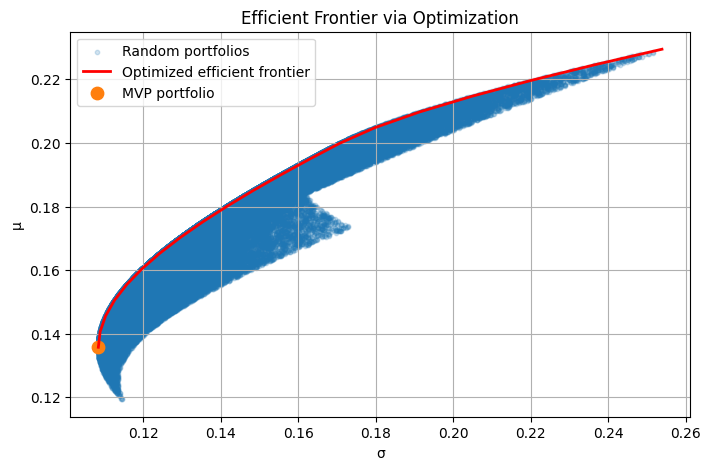

In [ ]:
# %% Solve for minimum variance portfolios across a range of target returns

target_returns = np.linspace(mu_mvp, mean_risky.max(), 20)

frontier_vol_opt = []
frontier_ret_opt = []

for tr in target_returns:
    w_tr = min_var_given_return(mean_risky, cov_risky, tr)
    mu_tr, sigma_tr = portfolio_stats(w_tr, mean_risky, cov_risky)
    frontier_ret_opt.append(mu_tr)
    frontier_vol_opt.append(sigma_tr)

fig, ax = plt.subplots()
ax.scatter(portfolios_df["vol"], portfolios_df["ret"], alpha=0.2, s=10, label="Random portfolios")
ax.plot(frontier_vol_opt, frontier_ret_opt, color='red', linewidth=2, label="Optimized efficient frontier")
ax.scatter([sigma_mvp], [mu_mvp], marker="o", s=80, label="MVP portfolio")
ax.set_xlabel("σ")
ax.set_ylabel("μ")
ax.set_title("Efficient Frontier via Optimization")
ax.legend()
plt.show()


## 5. CAPM-Style Regression and Beta

**CAPM** relates expected return to **beta**:

$\mu_i = r_F + \beta_i (\mu_M - r_F)$

Beta is the slope of the **regression line** of an asset’s return vs. the **market** return.  

We'll:

1. Choose a risk-free rate (toy value)  
2. Estimate betas for the three risky assets relative to our simulated `Market`  
3. Plot the **Capital Market Line (CML)** using estimated $\beta$ and $\mu$


In [ ]:
# %% Estimate betas via simple linear regression: r_i = alpha + beta * r_M + noise

from numpy.linalg import lstsq

risk_free_annual = 0.07
risk_free_monthly = risk_free_annual / 12

excess_market = returns_df["Market"] - risk_free_monthly

betas = {}
alphas = {}
mean_annual_asset = {}

for asset in risky_assets:
    excess_asset = returns_df[asset] - risk_free_monthly
    X = excess_market.values.reshape(-1, 1)
    y = excess_asset.values.reshape(-1, 1)

    # Add intercept term
    X_design = np.hstack([np.ones_like(X), X])
    coef, _, _, _ = lstsq(X_design, y, rcond=None)  # [alpha, beta]

    alpha_hat, beta_hat = coef.flatten()
    betas[asset] = beta_hat
    alphas[asset] = alpha_hat
    mean_annual_asset[asset] = (1 + returns_df[asset].mean())**12 - 1

betas, alphas


({'Defensive': np.float64(0.551343599714157),
  'Growth': np.float64(0.9696080058156932),
  'Cyclical': np.float64(0.6431289431346416)},
 {'Defensive': np.float64(-0.0007910790266471608),
  'Growth': np.float64(3.92225863213262e-05),
  'Cyclical': np.float64(0.007585811785913909)})

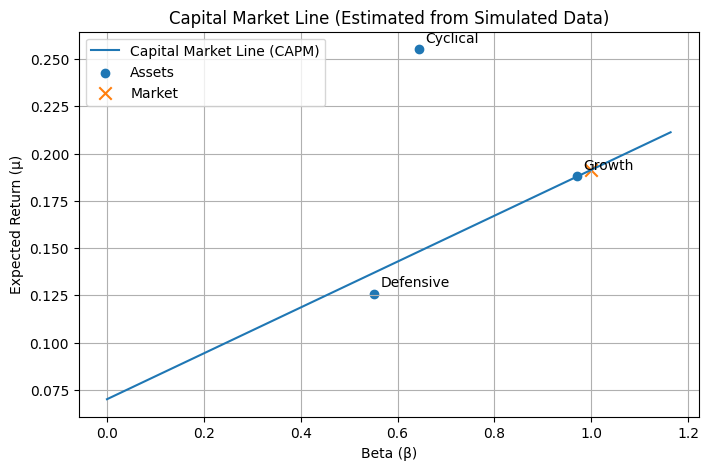

In [ ]:
# %% Plot Capital Market Line (CML)

beta_values = np.array(list(betas.values()))
mu_est_annual = np.array(list(mean_annual_asset.values()))

# "Market" point
beta_market = 1.0
mu_market = (1 + returns_df["Market"].mean())**12 - 1

# CAPM line: mu = r_f + beta * (mu_M - r_f)
beta_line = np.linspace(0, max(beta_values) * 1.2, 50)
sml_line = risk_free_annual + beta_line * (mu_market - risk_free_annual)

fig, ax = plt.subplots()
ax.plot(beta_line, sml_line, label="Capital Market Line (CAPM)")
ax.scatter(beta_values, mu_est_annual, marker="o", label="Assets")
for asset, b, mu in zip(risky_assets, beta_values, mu_est_annual):
    ax.annotate(asset, (b, mu), xytext=(5, 5), textcoords="offset points")

ax.scatter([beta_market], [mu_market], marker="x", s=80, label="Market")
ax.set_xlabel("Beta (β)")
ax.set_ylabel("Expected Return (μ)")
ax.set_title("Capital Market Line (Estimated from Simulated Data)")
ax.legend()
plt.show()


### Interpretation

- The **slope** of the CML is the **market risk premium** $\mu_M - r_F$.  
- Each asset has:
  - A **$\beta$** measuring sensitivity to market movements  
  - An approximate expected return estimated from data


## 6. Playground: Design Your Own Portfolio

Now it's your turn to experiment.

Ideas:

1. **Change the correlation matrix** at the top and re-run the entire notebook.  
2. Add a fourth risky asset and see how the Markowitz bullet changes.  
3. Fix a **target volatility** and search for the **maximum-return portfolio** at that risk.  
4. Re-estimate **betas** after changing the simulation parameters.

Try to connect each experiment back to the theory and slides:

- How does diversification change with correlation?  
- How does the efficient frontier move?  
- Do your assets approximately satisfy the CAPM relation?
